In [35]:
globals().clear()

import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np


os.chdir('C:/Users/lbeatty/Documents/Lauren_MIP_Contribution/')

scenario = '26z-thin-debug'
model='SWITCH'

In [36]:
# Read the shapefiles
states = gpd.read_file('tl_2022_us_state/tl_2022_us_state.shp')
states = states[~states['STUSPS'].isin(['AS', 'AK', 'GU', 'MP', 'VI', 'HI', 'PR'])]

emissions_2030 = gpd.read_file('InMap/MIP_InMap_Output/emissions2030_out.shp')

# Transform coordinates to match output
states = states.to_crs(emissions_2030.crs)

In [37]:
#make flag for intersecting land
# Perform spatial intersection
intersects = emissions_2030.geometry.intersects(states.unary_union)
emissions_2030['intersects'] = intersects
emissions_2030 = emissions_2030[~emissions_2030['intersects'].isna()]

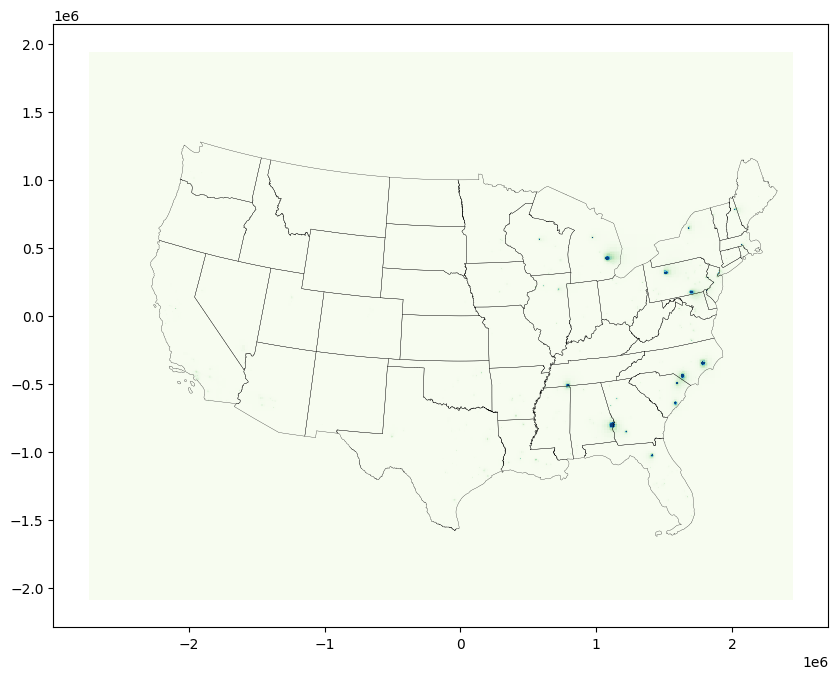

<Figure size 640x480 with 0 Axes>

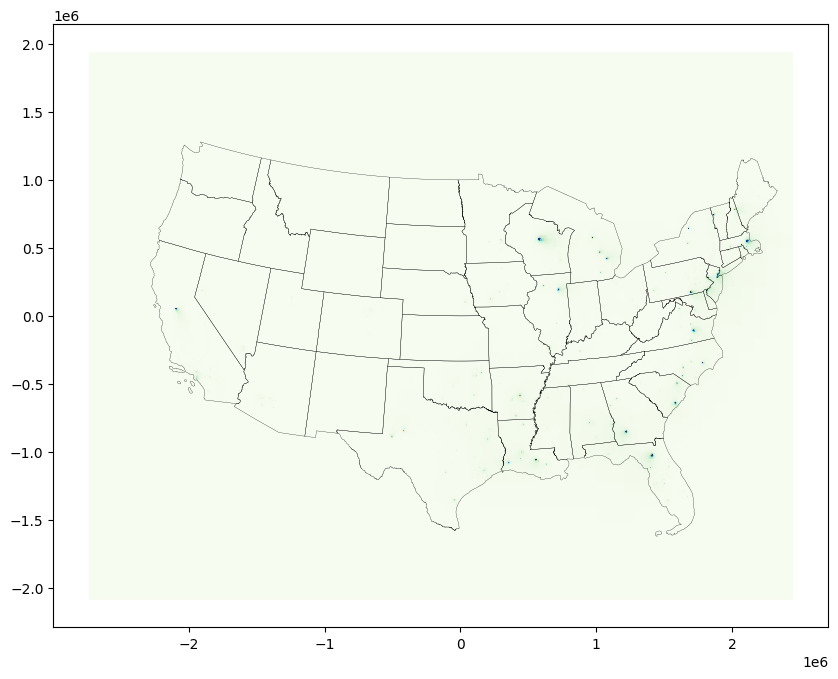

<Figure size 640x480 with 0 Axes>

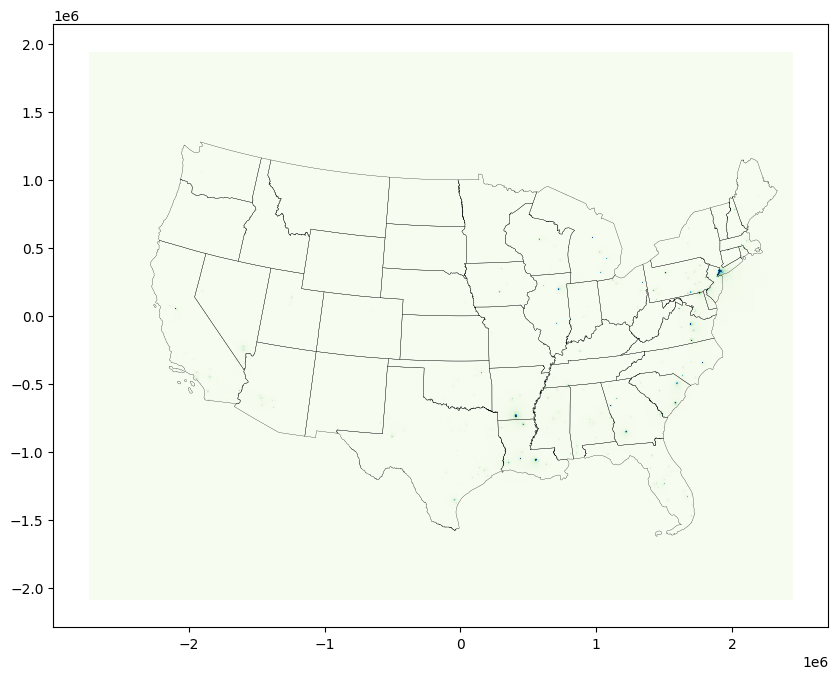

<Figure size 640x480 with 0 Axes>

In [40]:
# Plotting
columns_to_plot = ['SOx', 'NOx', 'PrimPM25']

for column in columns_to_plot:
    q = 0.99 # We are going to truncate our results at the 99.5th percentile
          # to make the maps easier to interpret.
    cut = np.quantile(emissions_2030[column], q)

    fig, ax = plt.subplots(figsize=(10, 8))

    emissions_2030.plot(vmin=0, vmax=cut, cmap="GnBu", column=column, ax=ax)
    states.boundary.plot(ax=ax, color='black', linewidth=0.2)

    plt.show()
    plt.savefig('MIP_AirPollution/Figures/Output/'+scenario+'/'+model+'/'+column+'.jpg', format='jpg', dpi=300)
